<a href="https://colab.research.google.com/github/cydal/tsExtract/blob/master/EnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
### https://www.kaggle.com/robikscube/hourly-energy-consumption?select=NI_hourly.csv

In [20]:
import pandas as pd
import numpy as np

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats


from helper import *
import xgboost

In [2]:
df = pd.read_csv("DAYTON_hourly.csv")
df["Datetime"] = pd.to_datetime(df["Datetime"])
df = df.set_index("Datetime")

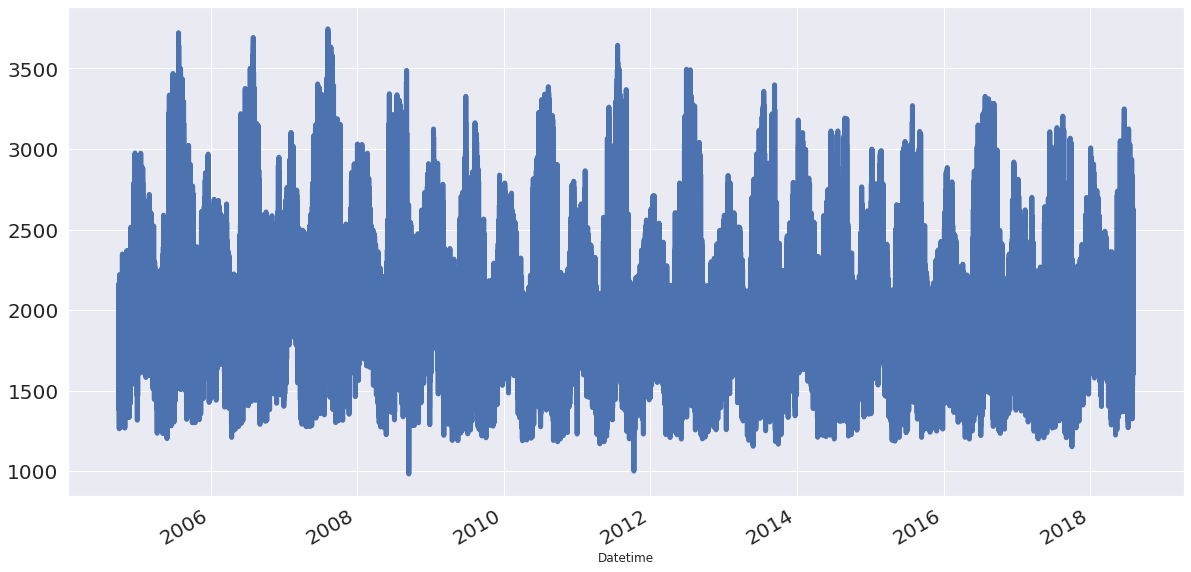

In [3]:
df["DAYTON_MW"].plot(figsize=(20,10), linewidth=5, fontsize=20)

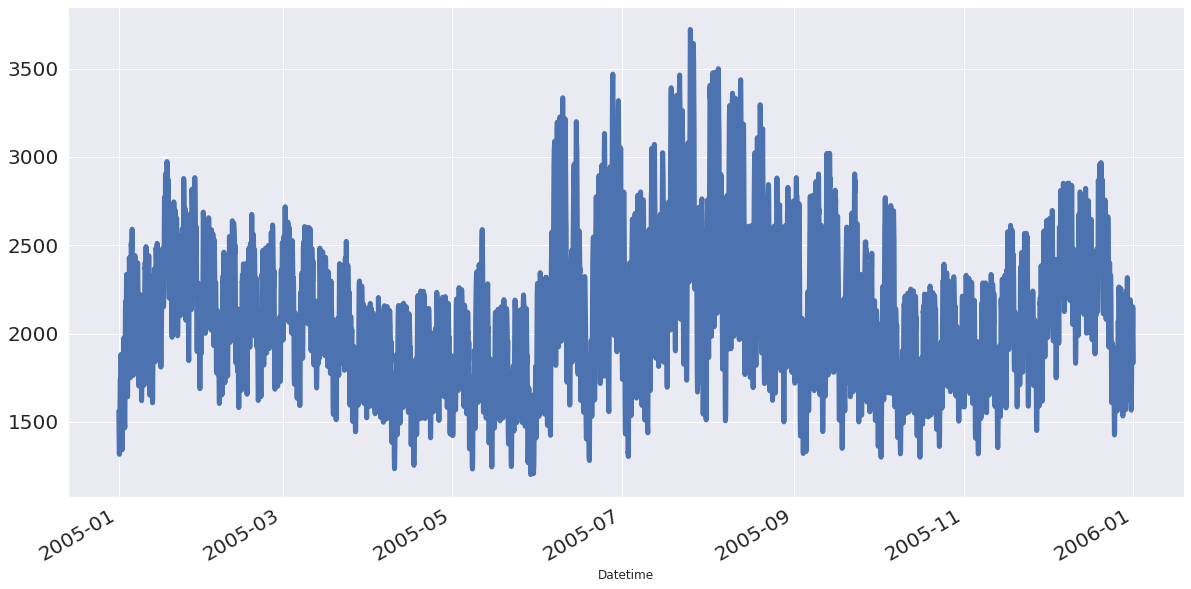

In [4]:
df["DAYTON_MW"][df.index.year == 2005].plot(figsize=(20,10), linewidth=5, fontsize=20)

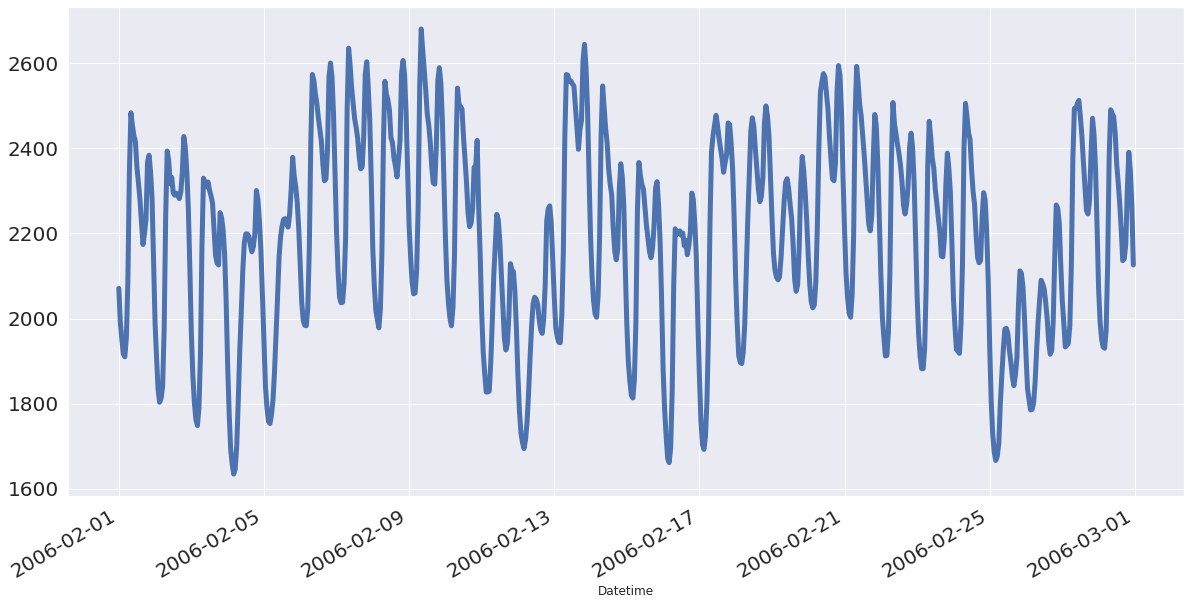

In [5]:
df["DAYTON_MW"][((df.index.year == 2006) & (df.index.month == 2))].plot(figsize=(20,10), linewidth=5, fontsize=20)

In [ ]:
## We can see both seasonality and Trend.

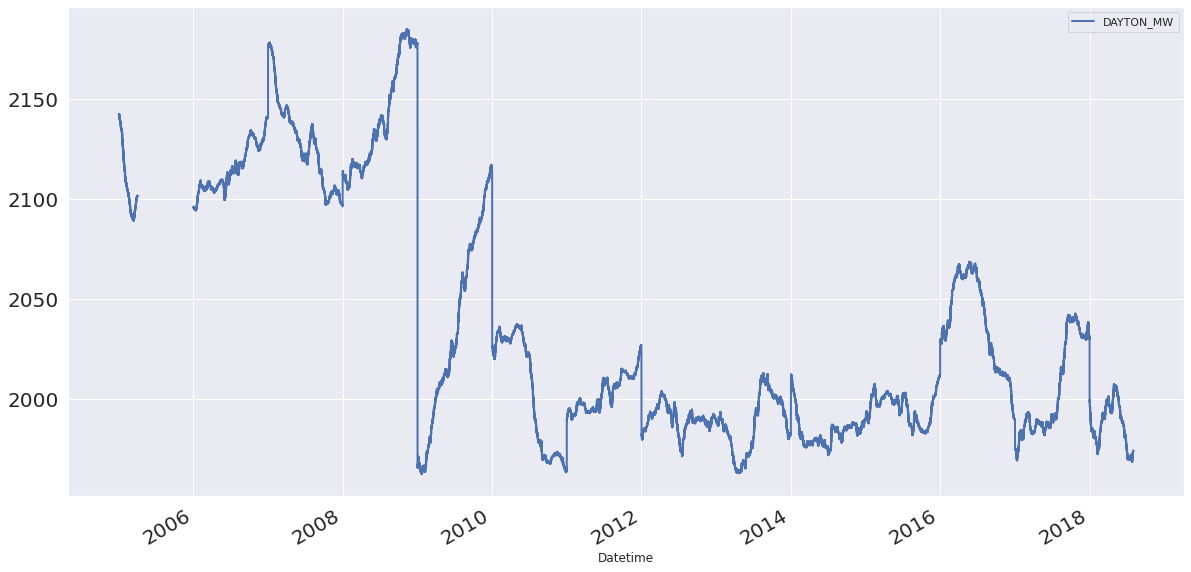

In [6]:
df[["DAYTON_MW"]].rolling(8760).mean().plot(figsize=(20,10), linewidth=2, fontsize=20)

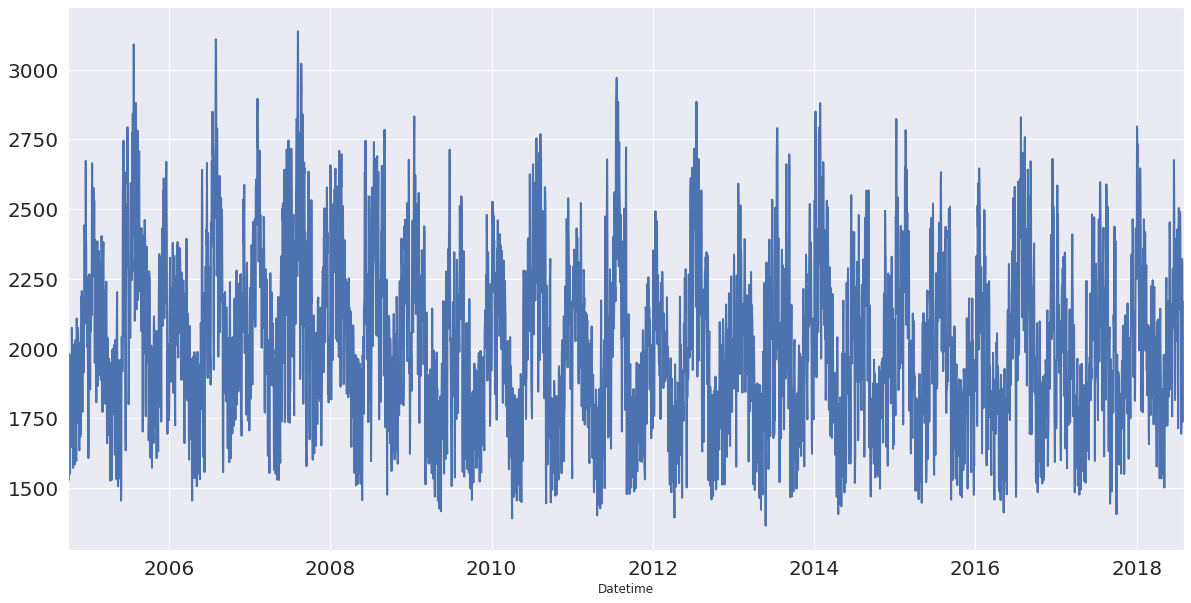

In [7]:
df["DAYTON_MW"].resample('D').mean().plot(figsize=(20,10), linewidth=2, fontsize=20)

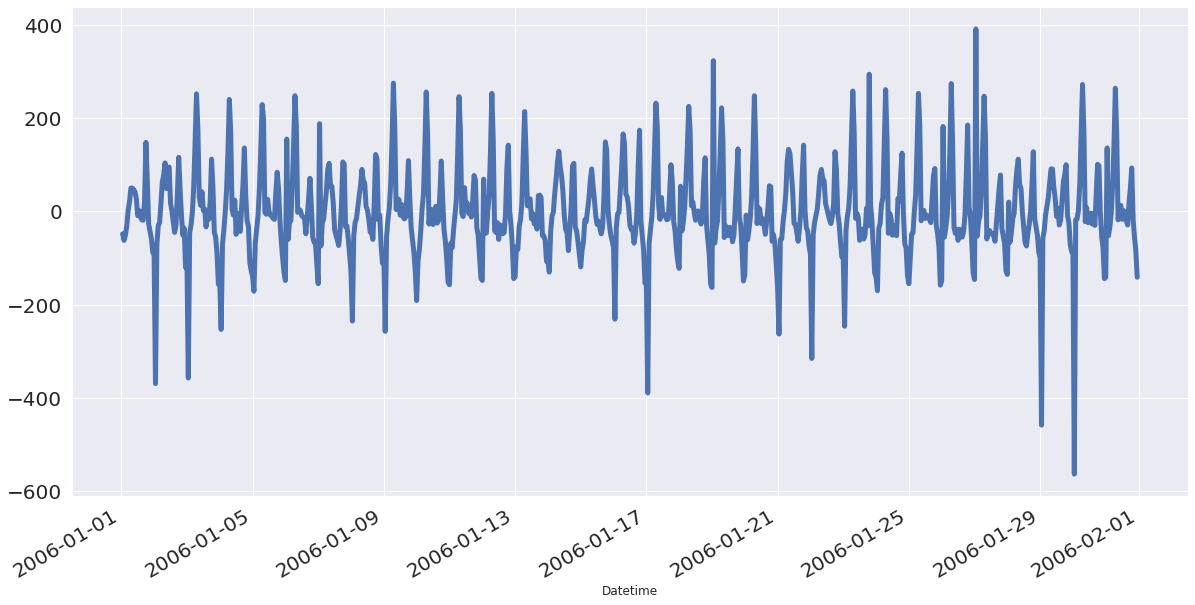

In [8]:
df["DAYTON_MW"][((df.index.year == 2006) & (df.index.month == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20)

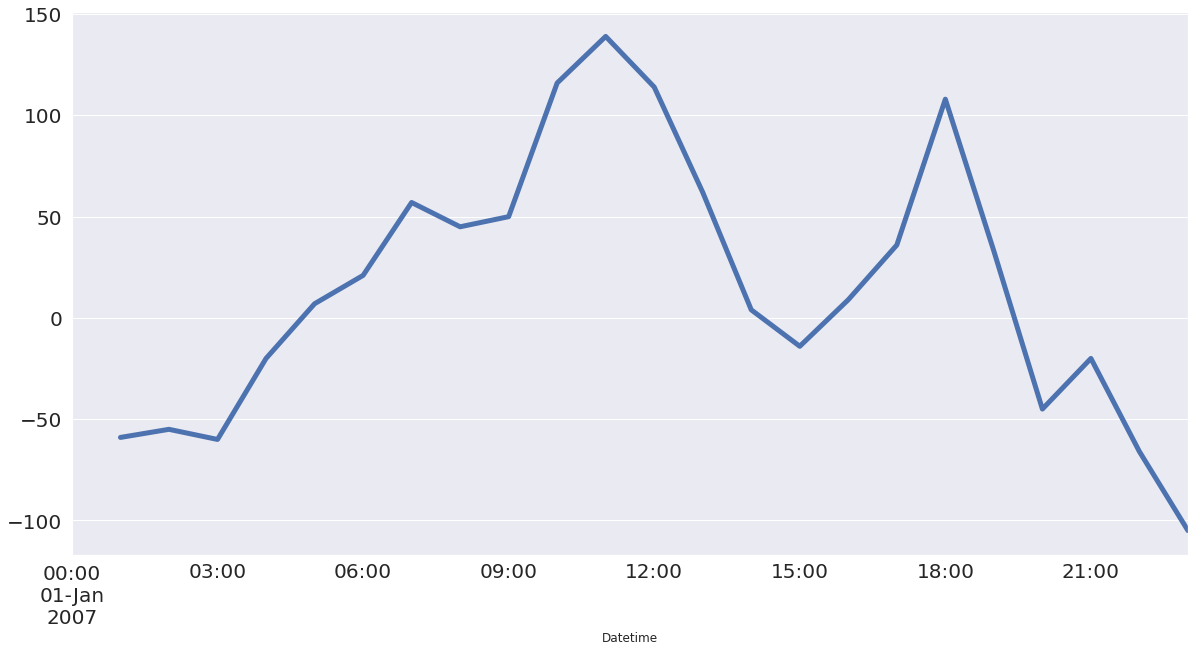

In [9]:
df["DAYTON_MW"][((df.index.year == 2007) & 
                 (df.index.month == 1) & 
                 (df.index.day == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20)

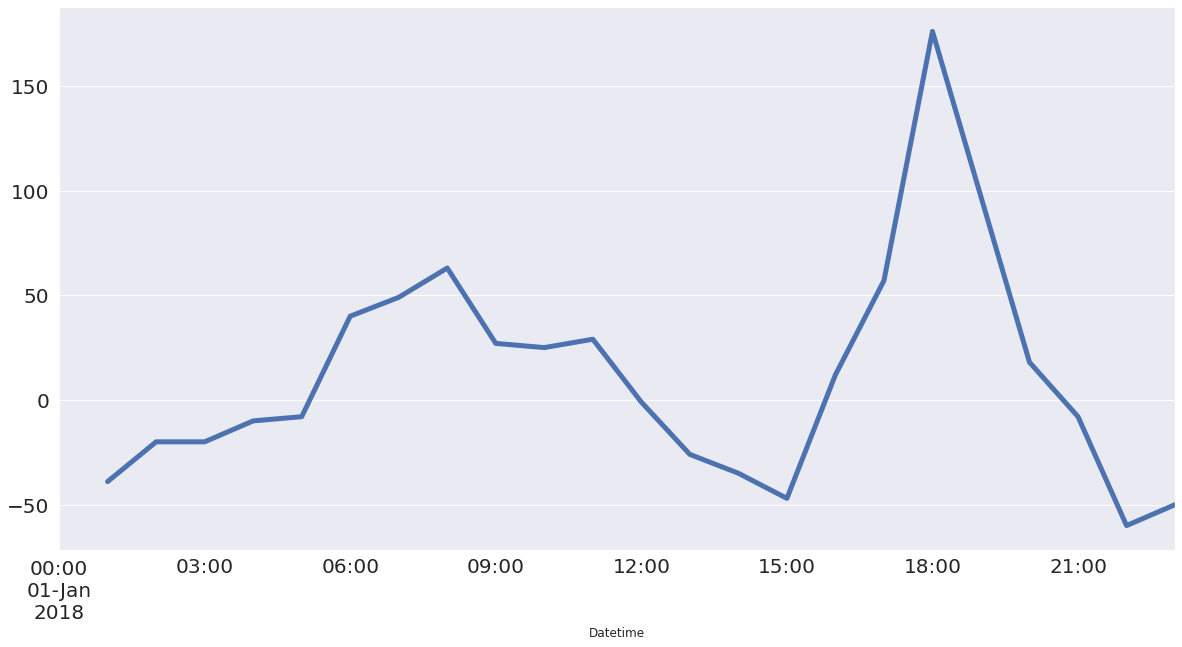

In [10]:
df["DAYTON_MW"][((df.index.year == 2018) & 
                 (df.index.month == 1) & 
                 (df.index.day == 1))].diff().plot(figsize=(20,10), linewidth=5, fontsize=20)

In [12]:
index = df.index
win_24 = window_list(df["DAYTON_MW"], 24)

In [13]:
df["DAYTON_MW"]

Datetime
2004-12-31 01:00:00    1596.0
2004-12-31 02:00:00    1517.0
2004-12-31 03:00:00    1486.0
2004-12-31 04:00:00    1469.0
2004-12-31 05:00:00    1472.0
                        ...  
2018-01-01 20:00:00    2732.0
2018-01-01 21:00:00    2724.0
2018-01-01 22:00:00    2664.0
2018-01-01 23:00:00    2614.0
2018-01-02 00:00:00    2552.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [14]:
difference(df["DAYTON_MW"], 1)

Datetime
2004-12-31 01:00:00     NaN
2004-12-31 02:00:00   -79.0
2004-12-31 03:00:00   -31.0
2004-12-31 04:00:00   -17.0
2004-12-31 05:00:00     3.0
                       ... 
2018-01-01 20:00:00    18.0
2018-01-01 21:00:00    -8.0
2018-01-01 22:00:00   -60.0
2018-01-01 23:00:00   -50.0
2018-01-02 00:00:00   -62.0
Name: DAYTON_MW, Length: 121275, dtype: float64

In [15]:
win_24_mean = win_stat(win_24, "mean")
win_24_diff = difference_comb(df["DAYTON_MW"], 24, 10, cutt=True)
win_24_diff.shape

(121275, 14)

In [16]:
combined_df = np.hstack((win_24, # Windowed Data - 24
           np.expand_dims(win_24_mean, axis=1), # Windowed Data MEAN - 1
           win_24_diff, # Windowed Data DIFF  - 25 - 10 = 14
           np.expand_dims(df["DAYTON_MW"], axis=1), # T + 0 - 1 
           np.expand_dims(df["DAYTON_MW"].shift(-18), axis=1))) # T + 18 Target - 1


combined_df.shape # 24 + 14 + 1 + 1 + 1 = 41

(121275, 41)

In [17]:
combined_df = cut_final(pd.DataFrame(combined_df))

In [19]:
train_size = int(combined_df.shape[0] * 0.8)

x_train, y_train = combined_df.iloc[:train_size, :-2], combined_df.iloc[:train_size, -1]
x_test, y_test = combined_df.iloc[train_size:, :-2], combined_df.iloc[train_size:, -1]

In [ ]:
x_train, y_train = combined_df.iloc[:train_size, :-2], combined_df.iloc[:train_size, -1]
x_test, y_test = combined_df.iloc[train_size:, :-2], combined_df.iloc[train_size:, -1]

In [21]:
model = xgboost.XGBRegressor(colsample_bytree=0.4,
                 objective="reg:squarederror",
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=100,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42) 

In [22]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0,
             importance_type='gain', learning_rate=0.07, max_delta_step=0,
             max_depth=3, min_child_weight=1.5, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0.75, reg_lambda=0.45,
             scale_pos_weight=1, seed=42, silent=None, subsample=0.6,
             verbosity=1)

In [23]:
pred = model.predict(x_test)

In [24]:
mean_squared_error(y_train, model.predict(x_train))

39064.48952918729

In [25]:
mean_squared_error(y_test, model.predict(x_test))

39696.946231352864

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

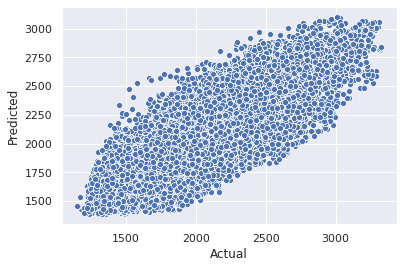

In [26]:
ax = sns.scatterplot(y_test, pred)
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Predicted'), Text(0.5, 0, 'Actual')]

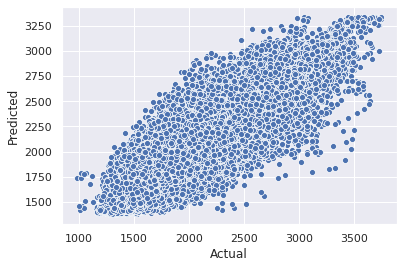

In [27]:
ax = sns.scatterplot(y_train, model.predict(x_train))
ax.set(xlabel='Actual', ylabel='Predicted')

[Text(0, 0.5, 'Y'), Text(0.5, 0, 'Time')]

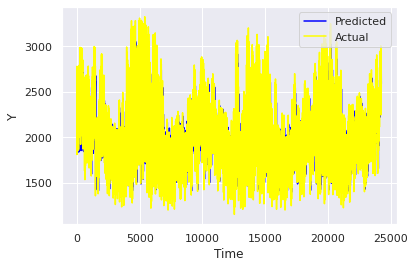

In [28]:
ax = sns.lineplot(range(x_test.shape[0]), model.predict(x_test), 
                  color="blue", label="Predicted", linestyle="-")
ax = sns.lineplot(range(x_test.shape[0]), y_test, 
                  color="yellow", label="Actual", linestyle="-")

ax.set(xlabel='Time', ylabel='Y')

In [29]:
lags = []
for c in range(-30, 30):
    lagged = pd.Series(pred).shift(c)
    lags.append(scipy.stats.spearmanr(lagged, y_test, nan_policy='omit')[0])

In [ ]:
def get_lag_corr(pred, actual, num_lags):
    lags = []
    for c in range(num_lags):
        lagged = pd.Series(pred).shift(c)
        lags.append(scipy.stats.spearmanr(lagged, actual, nan_policy='omit')[0])
        
    return(lags)

[Text(0, 0.5, 'Corr Coefficient'), Text(0.5, 0, 'Lag')]

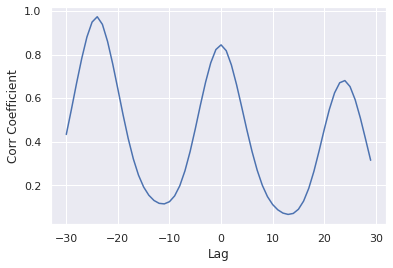

In [30]:
ax = sns.lineplot(range(-len(lags) // 2, len(lags) // 2), lags, linestyle="-")
ax.set(xlabel='Lag', ylabel='Corr Coefficient')

In [ ]:
## Lag Measure

# z(delta) =  (y(t+delta) * y_hat(t)) / sig(y)*sig(y_hat)
# kendalltau spearmanr pearsonr